# Подготовка данных

## Изучение датасета

Для обучения НС будет использоваться датасет RTSD (Russian Traffic Sign Dataset)
Выведем количество знаков, количество изображений и распределение областей по классам.

In [45]:
import pandas as pd

path = 'dataset/rtsd-frames/'

dataset = pd.read_csv('full-gt.csv')
dataset.head()

,filename,x_from,y_from,width,height,sign_class,sign_id
0,autosave01_02_2012_09_13_33.jpg,649,376,18,18,2_1,0
1,autosave01_02_2012_09_13_34.jpg,671,356,20,21,2_1,0
2,autosave01_02_2012_09_13_35.jpg,711,332,27,26,2_1,0
3,autosave01_02_2012_09_13_36.jpg,764,290,37,36,2_1,0
4,autosave01_02_2012_09_13_36.jpg,684,384,17,17,1_23,1


Взглянем на размеры изображений в датасете.

In [36]:
from PIL import Image
from collections import Counter
import numpy as np
from os import listdir

filenames = listdir(path)
sizes = []
for name in filenames:
    img = Image.open(path + name)
    sizes.append(str(img.size))
sizes = Counter(sizes)

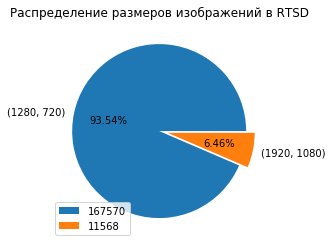

In [37]:
import matplotlib.pyplot as plt

plt.pie(sizes.values(), labels=sizes.keys(),
        explode=(0, 0.1), autopct='%1.2f%%')
plt.title('Распределение размеров изображений в RTSD')
plt.legend(sizes.values(), loc='lower left')
plt.show()

Судя по всему, в датасете есть немало неразмеченных кадров. Проверим:

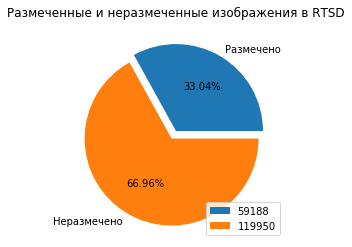

In [40]:
labeled_filenames = np.unique(dataset.filename)
labeled_length = len(labeled_filenames)
unlabeled_length = len(filenames)
files = { 'Размечено' : labeled_length, 'Неразмечено' : unlabeled_length - labeled_length }

plt.pie(files.values(), labels=files.keys(),
        explode=(0, 0.1), autopct='%1.2f%%')
plt.title('Размеченные и неразмеченные изображения в RTSD')
plt.legend(files.values(), loc='lower right')
plt.show()

Для обучения feature extractor'а такие изображения необходимы, так что это приемлимо.

Заодно проверим много ли неразмеченных изображений среди (1920, 1080). Есть подозрения, что их нет

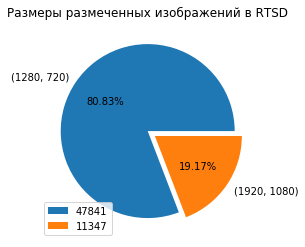

In [41]:
sizes = []
for name in labeled_filenames:
    img = Image.open(path + name)
    sizes.append(str(img.size))
sizes = Counter(sizes)

plt.pie(sizes.values(), labels=sizes.keys(),
        explode=(0, 0.1), autopct='%1.2f%%')
plt.title('Размеры размеченных изображений в RTSD')
plt.legend(sizes.values(), loc='lower left')
plt.show()

Таким образом неразмеченных изображений (1920, 1080) чуть более двухста штук. 

Для обучения понадобятся лишь изображения (1280, 720), поэтому изменим размер всех остальных изображений из full-gt.csv к необходимому. Неразмеченные изображения (1920, 1080) затем просто удалим.

In [42]:
def resize_image(new_size, filename):
    img = Image.open(filename)
    size = img.size
    if size != new_size:
        img = img.resize(new_size, Image.ANTIALIAS)
        img.save(filename)
    return np.divide(size, new_size)


def resize_box(ratio, box):
    horizontal, vertical = ratio
    x, y, width, height = box
    return [int(x / horizontal),
            int(y / vertical),
            int(width / horizontal),
            int(height / vertical)]


dataset = pd.read_csv('full-gt.csv')
values = dataset.values
columns = dataset.columns
indices = dataset.index

filename = None
ratio = None
for i in indices:
    row = values[i]
    if row[0] != filename:
        filename = row[0]
        ratio = resize_image(
            (1280, 720),
            path + filename
        )
    row[1:5] = resize_box(ratio, row[1:5])
pd.DataFrame(values, columns=columns).to_csv('new-full-gt.csv', index=False)

In [46]:
import os

filenames = listdir(path)
for file in filenames:
    if Image.open(path + file).size == (1920, 1080):
        os.remove(path + file)

На всякий случай проверим получилось ли:

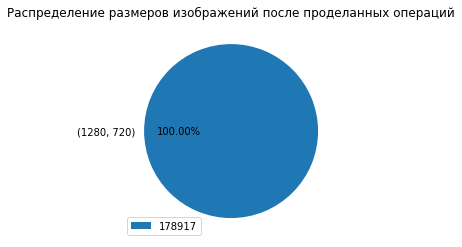

In [49]:
filenames = listdir(path)

sizes = []
for name in filenames:
    img = Image.open(path + name)
    sizes.append(str(img.size))
sizes = Counter(sizes)

plt.pie(sizes.values(), labels=sizes.keys(), autopct='%1.2f%%')
plt.title('Распределение размеров изображений после проделанных операций')
plt.legend(sizes.values(), loc='lower left')
plt.show()

Так же стоит взглянуть на распределение по классам

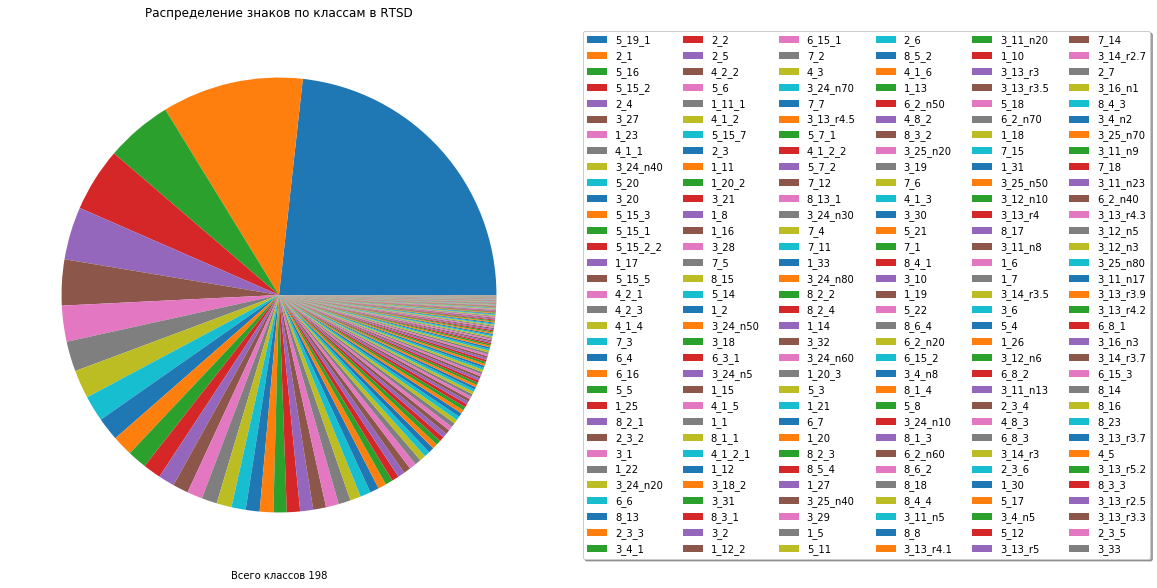

In [97]:
dataset = pd.read_csv('new-full-gt.csv')
classes = Counter(dataset.sign_class)
sorted_indices = np.argsort(list(classes.values()))[::-1]

plt.figure(figsize=(10,10))
plt.pie(np.take(list(classes.values()), sorted_indices),
        labels=None)
plt.title('Распределение знаков по классам в RTSD')
plt.legend(np.take(list(classes.keys()), sorted_indices),
           bbox_to_anchor=(1.05,0.5), loc="center left", ncol=6, fancybox=True, shadow=True)
plt.xlabel('Всего классов {}'.format(len(sorted_indices)))
plt.show()

Многие классы, насколько я понимаю, разбиты на группы. Например 3_25_n80 и 3_25_n40 - знаки ограничения скорости для 80 и 40 соответственно. Необходимо решить, как воспринимать эти знаки

Из векторов, содержащих информацию о наличии класса на изображении соберем матрицу, которую и будем использовать для обучения. Изображения, не содержащие знаки, будут иметь пометку в колонке background.

In [139]:
filenames = listdir(path)
dataset = pd.read_csv('new-full-gt.csv')[['filename', 'sign_class']]
classes = np.unique(dataset.sign_class)
groups = dataset.groupby('filename')['sign_class'].apply(list)
result = pd.DataFrame(filenames, columns=['filename'])

In [153]:
for name in classes:
    result[name] = 0
result['background'] = 0
for i in result.index:
    filename = filenames[i]
    if filename in groups.keys():
        for name in groups[filename]:
            result.at[i, name] = 1
    else:
        result.at[i, 'background'] = 1
result.to_csv('full.csv', index=False)

Скорее всего, после обучения на таких данных НС просто будет выдавать 0 в любом случае. Поэтому нужно уравнять ошибку с помощью весовых коэффициентов

In [161]:
total = len(listdir(path))
dataset = pd.read_csv('full-gt.csv')
classes = Counter(dataset.sign_class)
result = {key: [total / value] for key, value in classes.items()}
pd.DataFrame.from_dict(result, orient='index').to_csv('weights.csv')